# Homework 4: Change Detection

In [1]:
# if 'google.colab' in str(get_ipython()):
#     !pip install torchmetrics

In [2]:
# from google.colab import drive
# drive.mount('drive')

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

print(f"Using torch device type: {device}")

Using torch device type: cuda


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# Supervised Change Detection

For this programming assignment, you will be experimenting with a pixel-level labeling method for the task of foreground detection using a subset of the [changedetection.net](http://jacarini.dinf.usherbrooke.ca/) (links to an external site) dataset.  Most approaches to this problem use an unsupervised approach, in which you first learn what is normal for every pixel and then classify new pixels as normal (background) or abnormal (foreground).  We take a supervised learning approach using a convolutional neural network. We will be implementing this in PyTorch.

### Dataset Creation
We first create a dataset that allows us to read the image and appropriate labels from the data directory

In [6]:
#from drive.MyDrive.ColabNotebooks.dataset import MyDataset

# import sys
# sys.path.append('/content/drive/MyDrive/ColabNotebooks/dataset.py')

from dataset import MyDataset

In [7]:
def get_dataloaders(data_dir, batch_size=32, num_workers=2):
  #define train and test datasets
  train_data = MyDataset(data_dir)
  test_data = MyDataset(data_dir, train=False)
  test_data, valid_data = torch.utils.data.random_split(test_data, [0.5,0.5])
  #define train and test dataloaders
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
  test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=False, drop_last=True)
  valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=False, drop_last=True)

  return train_dataloader, test_dataloader, valid_dataloader

While not required, you can upload your data to your Google Drive, which will make it permanent. That way you will not need to upload the data everytime you restart your session.

Using `!` you can use terminal commands such as `!ls` or `!pwd` to find out the path to your data. Your Google Drive will have the path `./drive/MyDrive`.

Set `data_dir` variable to the appropriate path as it will be used to access the data throughout the rest of the notebook.

In [8]:
# !ls ./drive/MyDrive

In [9]:
# set the data directory to the appropriate directory
data_dir = './data/'
# set batch_size and number of workers
batch_size = 6
num_workers = 2
train_dataloader, test_dataloader, valid_dataloader = get_dataloaders(data_dir, batch_size, num_workers)

### Visualizing the Data
Once your dataloaders are ready, we can visualize our data. The code block plots a couple of examples from the training set. The left column shows your input and the right column shows the labels.

The labels only have three unique pixel values. The yellow pixels represent foreground, the dark pixels represent background, and the green pixels represent ignore classes.

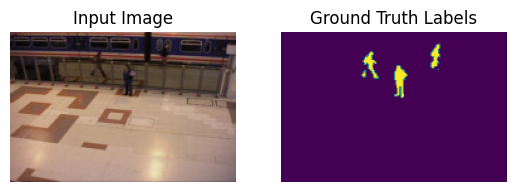

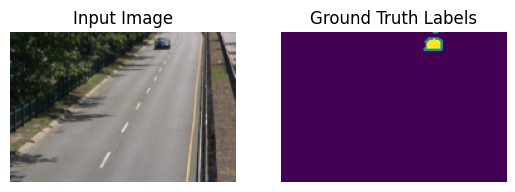

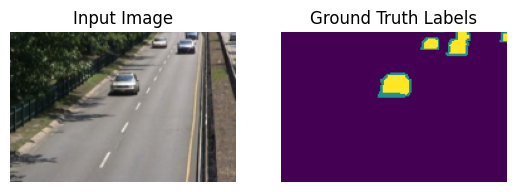

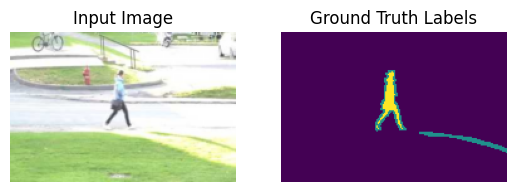

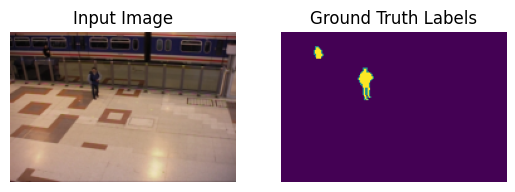

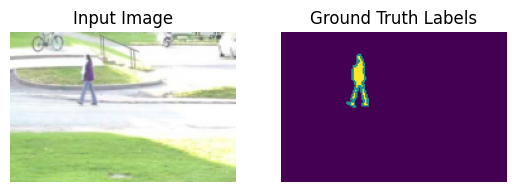

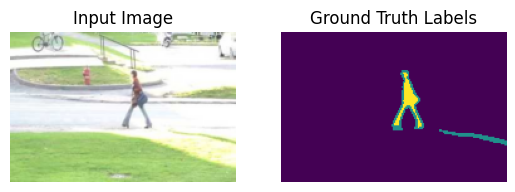

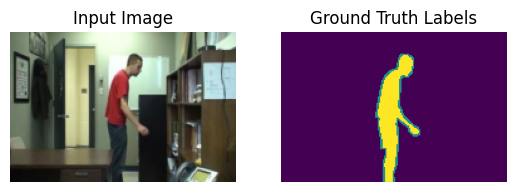

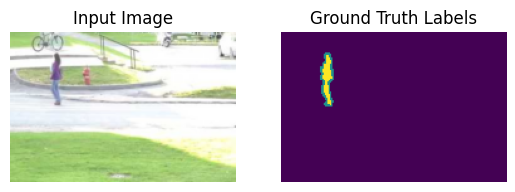

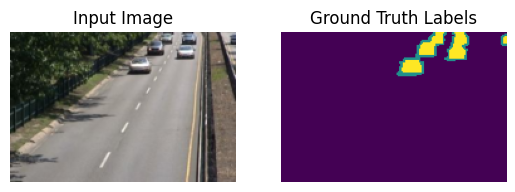

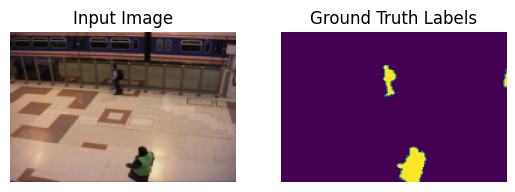

In [10]:
def visualize_data(dataloader):
  for index, (ims, labels) in enumerate(dataloader):
      labels = torch.permute(labels, (0,2,3,1))
      ims = torch.permute(ims, (0,2,3,1)).cpu()
      plt.figure(1)
      plt.clf()

      plt.subplot(1,2,1)
      plt.imshow(ims[0,:,:,:])
      plt.title('Input Image')
      plt.axis('off')

      plt.subplot(1,2,2)
      plt.imshow(labels[0,:,:,:].squeeze(),clim=(0.0,2.0))
      plt.title('Ground Truth Labels')
      plt.axis('off')

      plt.pause(.1)

      if index == 10:
          break

visualize_data(train_dataloader)

### Metrics
We will define three functions in this section: **precision**, **recall**, and **f1**. These metrics will allow us to evaluate the efficacy of our model.

In [11]:
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision
from tqdm import tqdm

def precision(y_true, y_pred):
  y_pred = torch.argmax(y_pred, dim=1, keepdim=True)
  prec = MulticlassPrecision(average='macro', num_classes=3, ignore_index=1).to(device)
  batch_precision = prec(y_true, y_pred)
  return batch_precision

def recall(y_true, y_pred):
  y_pred = torch.argmax(y_pred, dim=1, keepdim=True)
  rec = MulticlassRecall(average='macro', num_classes=3, ignore_index=1).to(device)
  batch_precision = rec(y_true, y_pred)
  return batch_precision

def f_measure(y_true, y_pred):
  p = precision(y_true, y_pred)
  r = recall(y_true, y_pred)
  fmeasure = 2*(p * r)/(p + r + 1e-7)
  return fmeasure

In [12]:
y_pred = torch.randn(3,3,120,180).to(device)
y_true = torch.randint(0, 3, size=(3, 1, 120, 180)).to(device)

In [13]:
print(f_measure(y_true, y_pred))

tensor(0.2673, device='cuda:0')


# Dealing With Class Imbalance

There are three classes in this task: 0) background, 1) unknown, and 2) foreground. Unfortunately, the training dataset has a "class balance" problem, meaning there are many more background pixels than foreground pixels. This can lead to a model that only predicts background. To overcome this problem, we have a special purpose loss function that enables different types of errors to be penalized differently. The default setting, is class_weights = [.25,0,1].  This means that:

Classifying a true foreground pixel as background or unknown has the highest loss.
Classifying a true background pixel as foreground or unknown has only 1/4 the penalty.
Classifying an unknown pixel results in no loss regardless of the resulting label.

Your task is to train three models:

- using the default class weight
- using class_weights= [.01,0,1]
- using class_weights= [1,0,1].  

Use the baseline neural network and optimizer settings for this task.  Include the Loss, Precision, Recall, and F-Measure for all three settings.  Also, explain what you observe in the **Discussion**.





In [14]:
class Baseline(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, (3,3), padding='same')
    self.bnorm1 = nn.BatchNorm2d(32, momentum=0.9, affine=False)
    self.conv2 = nn.Conv2d(32, 32, (3,3), padding='same')
    self.bnorm2 = nn.BatchNorm2d(32, momentum=0.9, affine=False)
    self.conv3 = nn.Conv2d(32, 3, (3,3), padding='same')

  def forward(self, x):
    x = self.bnorm1(nn.functional.leaky_relu(self.conv1(x), 0.1))
    x = self.bnorm2(nn.functional.leaky_relu(self.conv2(x), 0.1))
    output = self.conv3(x)
    return output

In [15]:
@torch.no_grad
def validate(model, dataloader,criterion):
  model.eval()
  model.to(device)
  running_loss = 0.0
  all_outputs = []
  all_labels = []
  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = torch.squeeze(labels, dim=1)
    labels = labels.type(torch.LongTensor)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)
    # Compute the loss
    loss = criterion(outputs, labels)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)

    #save all outputs
    all_outputs.append(outputs)
    all_labels.append(labels)

  # Calculate epoch loss and eval metrics
  epoch_loss = running_loss / len(dataloader.dataset)
  all_outputs = torch.cat(all_outputs, dim=0)
  all_labels = torch.cat(all_labels, dim=0)
  all_labels = torch.unsqueeze(all_labels, dim=1)
  f1 = f_measure(all_labels, all_outputs).item()

  print(f'Val Loss: {epoch_loss:.3f} \t F1-Score: {f1}')

  return epoch_loss, f1

In [16]:
def training_loop(model, dataloader,criterion,optimizer):
  model.train()
  model.to(device)
  running_loss = 0.0

  progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), position=0, leave=True)
  for i, (inputs, labels) in progress_bar:
    inputs = inputs.to(device)
    labels = torch.squeeze(labels, dim=1)
    labels = labels.type(torch.LongTensor)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # import code;code.interact(local=dict(globals(), **locals()))
    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    progress_bar.set_description(f"Train Loss: {loss.item()}")

  progress_bar.close()
  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  print(f"Train Loss: {epoch_loss:.3f}")

  return epoch_loss

In [17]:
def fit(hparams, train_loader, valid_loader, model_name='test'):
  model = hparams['model_type']()
  best_loss = np.inf
  f1 = 0

  results = dict(train_loss=[], val_loss=[], val_f1=[])
  #initialize the optimizers
  if hparams['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
  elif hparams['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'])
  else:
    raise NotImplementedError

  #initialize loss
  criterion = nn.CrossEntropyLoss(weight=torch.tensor(hparams['class_weights'], device=device, dtype=torch.float32))

  #run training for n epochs
  for epoch in range(hparams['n_epochs']):
    print("Epoch {}".format(epoch+1))
    train_loss = training_loop(model, train_loader,criterion,optimizer)
    val_loss, val_f1 = validate(model, valid_loader, criterion)

    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)
    results['val_f1'].append(val_f1)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model
      f1 = val_f1


  torch.save(best_model, f'{model_name}.pt')

  return best_model, best_loss, f1, results

In [18]:
def get_hparams(model_type=Baseline,n_epochs=10,learning_rate=1e-4, class_weights=[0.25, 0, 1], optimizer='adam'):
  hparams = {}
  hparams['n_epochs'] = n_epochs
  hparams['learning_rate'] = learning_rate
  hparams['model_type'] = model_type
  hparams['optimizer'] = optimizer
  hparams['class_weights'] = class_weights
  return hparams

Below, train 3 models using the different class weights defined earlier and display the results.

_Points:_ 5

In [19]:
# For students using an mps device, the following may reduce some warnings during training
# !export MallocStackLoggingNoCompact=1

In [20]:
# provide your training code below, and save your results to the variable "results"
results = []

# Code Goes Here:
#######################################
...
# Define class weights to test
class_weights_list = [
    [0.25, 0, 1],
    [0.01, 0, 1],
    [1, 0, 1]
]

for cw in class_weights_list:
    # Set hyperparameters
    hparams = get_hparams(
        model_type=Baseline,
        n_epochs=10,
        learning_rate=1e-4,
        class_weights=cw,
        optimizer='adam'
    )

    # Train the model
    best_model, best_loss, f1, _ = fit(
        hparams,
        train_dataloader,
        valid_dataloader,
        model_name=f'baseline_cw_{cw}'
    )

    # Save results
    results.append((cw, best_loss, f1))

# Display results
df = pd.DataFrame(results, columns=["Class Weights", "Best Validation Loss", "F1 Score"])
print(df)
#######################################


Epoch 1


Train Loss: 0.8456015586853027: 100%|██████████| 394/394 [00:18<00:00, 21.05it/s]


Train Loss: 0.943


100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Val Loss: 0.805 	 F1-Score: 0.4756709337234497
Epoch 2


Train Loss: 0.5047006011009216: 100%|██████████| 394/394 [00:18<00:00, 21.68it/s] 


Train Loss: 0.632


100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


Val Loss: 0.566 	 F1-Score: 0.4672119915485382
Epoch 3


Train Loss: 0.35950177907943726: 100%|██████████| 394/394 [00:18<00:00, 21.19it/s]


Train Loss: 0.415


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


Val Loss: 0.353 	 F1-Score: 0.514720618724823
Epoch 4


Train Loss: 0.4966776371002197: 100%|██████████| 394/394 [00:17<00:00, 22.31it/s] 


Train Loss: 0.297


100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


Val Loss: 0.312 	 F1-Score: 0.5203995704650879
Epoch 5


Train Loss: 0.250654399394989: 100%|██████████| 394/394 [00:18<00:00, 21.44it/s]  


Train Loss: 0.233


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


Val Loss: 0.250 	 F1-Score: 0.5362891554832458
Epoch 6


Train Loss: 0.2154778391122818: 100%|██████████| 394/394 [00:17<00:00, 22.43it/s] 


Train Loss: 0.194


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


Val Loss: 0.392 	 F1-Score: 0.4689963757991791
Epoch 7


Train Loss: 0.1936729997396469: 100%|██████████| 394/394 [00:16<00:00, 24.01it/s] 


Train Loss: 0.168


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Val Loss: 0.395 	 F1-Score: 0.46933236718177795
Epoch 8


Train Loss: 0.17099401354789734: 100%|██████████| 394/394 [00:17<00:00, 22.30it/s]


Train Loss: 0.151


100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


Val Loss: 0.450 	 F1-Score: 0.46810638904571533
Epoch 9


Train Loss: 0.15335685014724731: 100%|██████████| 394/394 [00:17<00:00, 22.61it/s]


Train Loss: 0.136


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


Val Loss: 0.256 	 F1-Score: 0.5240415930747986
Epoch 10


Train Loss: 0.11330673843622208: 100%|██████████| 394/394 [00:15<00:00, 24.81it/s]


Train Loss: 0.127


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


Val Loss: 0.212 	 F1-Score: 0.5342715382575989
Epoch 1


Train Loss: 1.1859875917434692: 100%|██████████| 394/394 [00:17<00:00, 22.85it/s] 


Train Loss: 0.568


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Val Loss: 0.328 	 F1-Score: 0.40482667088508606
Epoch 2


Train Loss: 0.16771279275417328: 100%|██████████| 394/394 [00:15<00:00, 25.11it/s]


Train Loss: 0.441


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


Val Loss: 0.308 	 F1-Score: 0.43072235584259033
Epoch 3


Train Loss: 0.6810652017593384: 100%|██████████| 394/394 [00:17<00:00, 23.11it/s] 


Train Loss: 0.401


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


Val Loss: 0.323 	 F1-Score: 0.40711709856987
Epoch 4


Train Loss: 0.46666622161865234: 100%|██████████| 394/394 [00:15<00:00, 26.02it/s]


Train Loss: 0.361


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


Val Loss: 0.297 	 F1-Score: 0.4081316590309143
Epoch 5


Train Loss: 0.4045845568180084: 100%|██████████| 394/394 [00:17<00:00, 22.24it/s] 


Train Loss: 0.330


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


Val Loss: 0.250 	 F1-Score: 0.4213390350341797
Epoch 6


Train Loss: 0.41052645444869995: 100%|██████████| 394/394 [00:17<00:00, 22.74it/s]


Train Loss: 0.294


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


Val Loss: 0.226 	 F1-Score: 0.44494032859802246
Epoch 7


Train Loss: 0.5232647657394409: 100%|██████████| 394/394 [00:19<00:00, 20.49it/s] 


Train Loss: 0.265


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Val Loss: 0.208 	 F1-Score: 0.44152942299842834
Epoch 8


Train Loss: 0.3122350871562958: 100%|██████████| 394/394 [00:15<00:00, 25.61it/s] 


Train Loss: 0.240


100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


Val Loss: 0.192 	 F1-Score: 0.44379010796546936
Epoch 9


Train Loss: 0.23447217047214508: 100%|██████████| 394/394 [00:17<00:00, 22.71it/s]


Train Loss: 0.220


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


Val Loss: 0.180 	 F1-Score: 0.44857341051101685
Epoch 10


Train Loss: 0.4203985929489136: 100%|██████████| 394/394 [00:17<00:00, 22.45it/s] 


Train Loss: 0.203


100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Val Loss: 0.227 	 F1-Score: 0.4392264485359192
Epoch 1


Train Loss: 0.6918906569480896: 100%|██████████| 394/394 [00:15<00:00, 25.25it/s]


Train Loss: 0.864


100%|██████████| 32/32 [00:12<00:00,  2.46it/s]


Val Loss: 0.711 	 F1-Score: 0.45836538076400757
Epoch 2


Train Loss: 0.3468016982078552: 100%|██████████| 394/394 [00:14<00:00, 27.33it/s] 


Train Loss: 0.515


100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


Val Loss: 0.322 	 F1-Score: 0.48428642749786377
Epoch 3


Train Loss: 0.45725253224372864: 100%|██████████| 394/394 [00:17<00:00, 21.94it/s]


Train Loss: 0.327


100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


Val Loss: 0.353 	 F1-Score: 0.4791404902935028
Epoch 4


Train Loss: 0.2455538660287857: 100%|██████████| 394/394 [00:17<00:00, 22.96it/s] 


Train Loss: 0.230


100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


Val Loss: 0.446 	 F1-Score: 0.45950281620025635
Epoch 5


Train Loss: 0.1929873824119568: 100%|██████████| 394/394 [00:16<00:00, 24.34it/s] 


Train Loss: 0.174


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Val Loss: 0.427 	 F1-Score: 0.4577927589416504
Epoch 6


Train Loss: 0.1821938455104828: 100%|██████████| 394/394 [00:16<00:00, 24.61it/s] 


Train Loss: 0.142


100%|██████████| 32/32 [00:15<00:00,  2.12it/s]


Val Loss: 0.153 	 F1-Score: 0.5105205178260803
Epoch 7


Train Loss: 0.12846612930297852: 100%|██████████| 394/394 [00:18<00:00, 21.02it/s]


Train Loss: 0.120


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


Val Loss: 0.232 	 F1-Score: 0.4943600296974182
Epoch 8


Train Loss: 0.14524807035923004: 100%|██████████| 394/394 [00:18<00:00, 21.85it/s]


Train Loss: 0.105


100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


Val Loss: 0.136 	 F1-Score: 0.5170522928237915
Epoch 9


Train Loss: 0.11646425724029541: 100%|██████████| 394/394 [00:17<00:00, 22.07it/s]


Train Loss: 0.094


100%|██████████| 32/32 [00:15<00:00,  2.12it/s]


Val Loss: 0.559 	 F1-Score: 0.4444922208786011
Epoch 10


Train Loss: 0.08871427923440933: 100%|██████████| 394/394 [00:18<00:00, 21.74it/s] 


Train Loss: 0.086


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Val Loss: 0.178 	 F1-Score: 0.5162926912307739
  Class Weights  Best Validation Loss  F1 Score
0  [0.25, 0, 1]              0.211711  0.534272
1  [0.01, 0, 1]              0.179794  0.448573
2     [1, 0, 1]              0.135610  0.517052


In [21]:
# Report your results using the below line
# The expected results format is shown below:
# results = [
#     ([.25, 0, 1], val_loss, f1_score),
#     ([.01, 0, 1], val_loss, f1_score),
#     ([1, 0, 1], val_loss, f1_score),
# ]

df = pd.DataFrame(results, columns=["Class Weights", "Best Validation Loss", "F1 Score"])
df

,Class Weights,Best Validation Loss,F1 Score
0,"[0.25, 0, 1]",0.211711,0.534272
1,"[0.01, 0, 1]",0.179794,0.448573
2,"[1, 0, 1]",0.135610,0.517052


# Define Custom Models
We provided a simple `Baseline` model as a reference. In this section you will create atleast two new Models. Try to make distinct choices between the two models. Feel free to experiment with different layers, architectures, regularization, size etc.   

In [22]:
class Model1(nn.Module):
  def __init__(self):
    super().__init__()
    ######## CODE BELOW ############
    ...
    self.conv1 = nn.Conv2d(3, 64, 3, padding='same')
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, 3, padding='same')
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, 3, padding='same')
    self.bn3 = nn.BatchNorm2d(256)
    self.dropout = nn.Dropout(0.5)
    self.final_conv = nn.Conv2d(256, 3, 1)
    ######## CODE ABOVE ############

  def forward(self, x):
    ####### CODE BELOW ############
    ...
    x = nn.functional.leaky_relu(self.bn1(self.conv1(x)), 0.1)
    x = nn.functional.leaky_relu(self.bn2(self.conv2(x)), 0.1)
    x = self.dropout(x)
    x = nn.functional.leaky_relu(self.bn3(self.conv3(x)), 0.1)
    x = self.final_conv(x)
    output = x

    ####### CODE ABOVE ############
    return output

# verify instantiability
model1 = Model1()
inputs = torch.rand(2,3,64,64)
print(inputs.device)
model1(inputs).shape


cpu


torch.Size([2, 3, 64, 64])

In [23]:
class Model2(nn.Module):
  def __init__(self):
    super().__init__()
    ######## CODE BELOW ############
    self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
    self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
    )

    # Decoder
    self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Upsamples to 60x90
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
    self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsamples to 120x180
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
    self.final_conv = nn.Conv2d(32, 3, 1)  # Output channels = num_classes (3)
    ######## CODE ABOVE ############

  def forward(self, x):
    ####### CODE BELOW ############
    x = self.enc1(x)  # Shape: (N, 64, H/2, W/2)
    x = self.enc2(x)  # Shape: (N, 128, H/4, W/4)
    x = self.dec1(x)  # Shape: (N, 64, H/2, W/2)
    x = self.dec2(x)  # Shape: (N, 32, H, W)
    x = self.final_conv(x)  # Shape: (N, 3, H, W)
    output = x
    ####### CODE ABOVE ############
    return output

# verify instantiability
model2 = Model2()
inputs = torch.rand(2,3,64,64)
print(inputs.device)
model2(inputs).shape


cpu


torch.Size([2, 3, 64, 64])

### Experimenting With Hyperparameters
You will run fit on each of the above models atleast once. After that you can experiment with any combination of models and hyperparameters including and beyond the list provided in the `get_hparams` function. Feel free to add new keys to the hparams dictionary as needed. Everytime you run the `fit` script, the best model from that run gets saved as `{model_name}.pt`. This is saved in the temporary directory so make sure to move it to your desired directory in the drive to use it later (or just set the intented directory in the fit funtion). You will also plot the validation loss and f1-score for the training runs.

We provide a `load_model` function that allows you to load a save model. Note that the respective model class has to be defined to use this functionality

In [24]:
def load_model(path):
  model = torch.load(path, weights_only=False)
  return model

<!-- BEGIN QUESTION -->



Epoch 1


Train Loss: 0.0845603346824646: 100%|██████████| 394/394 [01:06<00:00,  5.93it/s]  


Train Loss: 0.159


100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


Val Loss: 0.169 	 F1-Score: 0.5574579238891602
Epoch 2


Train Loss: 0.05356479808688164: 100%|██████████| 394/394 [01:11<00:00,  5.47it/s] 


Train Loss: 0.090


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Val Loss: 0.124 	 F1-Score: 0.580053985118866
Epoch 3


Train Loss: 0.07204336673021317: 100%|██████████| 394/394 [01:19<00:00,  4.97it/s] 


Train Loss: 0.069


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Val Loss: 0.096 	 F1-Score: 0.5861751437187195
Epoch 4


Train Loss: 0.09912998974323273: 100%|██████████| 394/394 [01:20<00:00,  4.89it/s] 


Train Loss: 0.057


100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


Val Loss: 0.100 	 F1-Score: 0.6015365719795227
Epoch 5


Train Loss: 0.019569193944334984: 100%|██████████| 394/394 [01:23<00:00,  4.74it/s]


Train Loss: 0.048


100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


Val Loss: 0.073 	 F1-Score: 0.594950258731842
Epoch 6


Train Loss: 0.02566448040306568: 100%|██████████| 394/394 [01:31<00:00,  4.32it/s] 


Train Loss: 0.044


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


Val Loss: 0.083 	 F1-Score: 0.5983547568321228
Epoch 7


Train Loss: 0.05101260170340538: 100%|██████████| 394/394 [01:32<00:00,  4.25it/s] 


Train Loss: 0.040


100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


Val Loss: 0.060 	 F1-Score: 0.6006069779396057
Epoch 8


Train Loss: 0.07399305701255798: 100%|██████████| 394/394 [01:35<00:00,  4.13it/s] 


Train Loss: 0.035


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


Val Loss: 0.051 	 F1-Score: 0.6107211709022522
Epoch 9


Train Loss: 0.1115167960524559: 100%|██████████| 394/394 [01:36<00:00,  4.07it/s]  


Train Loss: 0.031


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


Val Loss: 0.076 	 F1-Score: 0.6069605946540833
Epoch 10


Train Loss: 0.03528279811143875: 100%|██████████| 394/394 [01:39<00:00,  3.96it/s] 


Train Loss: 0.032


100%|██████████| 32/32 [00:22<00:00,  1.41it/s]


Val Loss: 0.067 	 F1-Score: 0.6002978682518005
Epoch 1


Train Loss: 0.038124777376651764: 100%|██████████| 394/394 [00:17<00:00, 21.90it/s]


Train Loss: 0.207


100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Val Loss: 0.145 	 F1-Score: 0.5743022561073303
Epoch 2


Train Loss: 0.013429573737084866: 100%|██████████| 394/394 [00:18<00:00, 21.32it/s]


Train Loss: 0.043


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


Val Loss: 0.062 	 F1-Score: 0.6075525283813477
Epoch 3


Train Loss: 0.040085069835186005: 100%|██████████| 394/394 [00:18<00:00, 21.75it/s]


Train Loss: 0.028


100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


Val Loss: 0.049 	 F1-Score: 0.6131722927093506
Epoch 4


Train Loss: 0.020078277215361595: 100%|██████████| 394/394 [00:18<00:00, 21.50it/s]


Train Loss: 0.019


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Val Loss: 0.050 	 F1-Score: 0.6107912659645081
Epoch 5


Train Loss: 0.0857454463839531: 100%|██████████| 394/394 [00:18<00:00, 21.37it/s]   


Train Loss: 0.016


100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


Val Loss: 0.155 	 F1-Score: 0.5397746562957764
Epoch 6


Train Loss: 0.024928059428930283: 100%|██████████| 394/394 [00:18<00:00, 21.38it/s] 


Train Loss: 0.016


100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


Val Loss: 0.062 	 F1-Score: 0.5977091789245605
Epoch 7


Train Loss: 0.020476486533880234: 100%|██████████| 394/394 [00:18<00:00, 21.72it/s] 


Train Loss: 0.015


100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


Val Loss: 0.058 	 F1-Score: 0.6145479679107666
Epoch 8


Train Loss: 0.0754178836941719: 100%|██████████| 394/394 [00:18<00:00, 21.41it/s]   


Train Loss: 0.010


100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Val Loss: 0.038 	 F1-Score: 0.6157184839248657
Epoch 9


Train Loss: 0.022127090021967888: 100%|██████████| 394/394 [00:18<00:00, 21.24it/s] 


Train Loss: 0.011


100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


Val Loss: 0.061 	 F1-Score: 0.6149013042449951
Epoch 10


Train Loss: 0.01206875778734684: 100%|██████████| 394/394 [00:18<00:00, 21.23it/s]  


Train Loss: 0.010


100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


Val Loss: 0.048 	 F1-Score: 0.6172821521759033


Text(0.5, 1.0, 'Validation Loss')

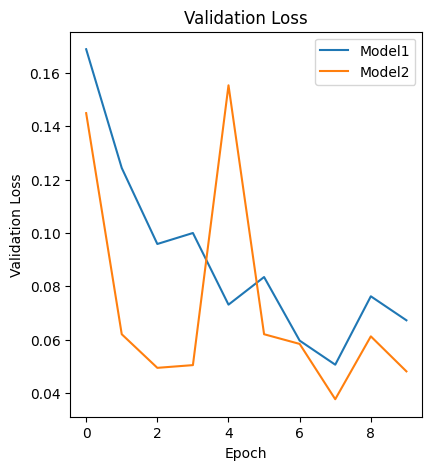

In [38]:
## Fit and plot results below

# use different calls to get_hparams to access different models and hyperparameters
# e.g.   > hparams = get_hparams()
#        > model, val_loss, f1, results = fit(hparams, train_dataloader, valid_dataloader, model_name='')

######## CODE BELOW ############
...
learning_rates = [1e-3]
results1 = []
results2 = []

for lr in learning_rates:
    hparams = get_hparams(
        model_type=Model1,
        n_epochs=10,
        learning_rate=lr,
        class_weights=[0.25, 0, 1],
        optimizer='adam'
    )

    _, _, _, results = fit(hparams, train_dataloader, valid_dataloader, f'model1_lr_{lr}')
    results1.append(results)
    
for lr in learning_rates:
    hparams = get_hparams(
        model_type=Model2,
        n_epochs=10,
        learning_rate=lr,
        class_weights=[0.25, 0, 1],
        optimizer='adam'
    )

    _, _, _, results = fit(hparams, train_dataloader, valid_dataloader, f'model1_lr_{lr}')
    results2.append(results)

######## CODE ABOVE ############

# write code to plot the f1 and val_loss across different epochs for each run
# Hint: use the results variable returned by fit. Make sure the plots are visible in the output below

######## CODE BELOW ############
...
plt.figure(figsize=(10, 5))
# for i, results in enumerate(all_results):
#     plt.plot(results['val_loss'], label=f'LR={learning_rates[i]}')
ax = plt.subplot(1, 2, 1)
ax.plot(results1[0]['val_loss'], label='Model1')
ax.plot(results2[0]['val_loss'], label='Model2')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss')

######## CODE ABOVE ############


<!-- END QUESTION -->

### Visualize the results on the test set

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad
def visualize(model, dataloader):
  for index, (ims, labels) in enumerate(dataloader):
      ims = ims.to(device)
      labels_est = model(ims)
      # import code;code.interact(local=dict(globals(), **locals()))
      labels = torch.permute(labels, (0,2,3,1)).cpu()
      labels_est = torch.permute(labels_est, (0,2,3,1)).cpu()
      ims = torch.permute(ims, (0,2,3,1)).cpu()
      plt.figure(figsize=(15,8))
      plt.clf()

      num_img = np.random.randint(0,batch_size)
      plt.subplot(1,4,1)
      plt.imshow(ims[num_img,:,:,:])
      plt.title('Input Image')
      plt.axis('off')

      plt.subplot(1,4,2)
      plt.imshow(labels[num_img,:,:,:].squeeze(),clim=(0.0,2.0))
      plt.title('Ground Truth Labels')
      plt.axis('off')

      plt.subplot(1,4,3)
      plt.imshow(labels_est[num_img,:,:,2].squeeze(),clim=(0.0,1.0))
      plt.title('Probability of Foreground')
      plt.axis('off')

      plt.subplot(1,4,4)
      plt.imshow(np.argmax(labels_est[num_img,:,:,:],axis=-1),clim=(0.0,2.0))
      plt.title('Predicted Labels')
      plt.axis('off')

      plt.pause(.1)

      if index == 10:
          break

<!-- BEGIN QUESTION -->

Visualize your best model's performance below.

_Points:_ 5

In [ ]:
# load your saved model
model = load_model('model1_lr_0.001.pt')

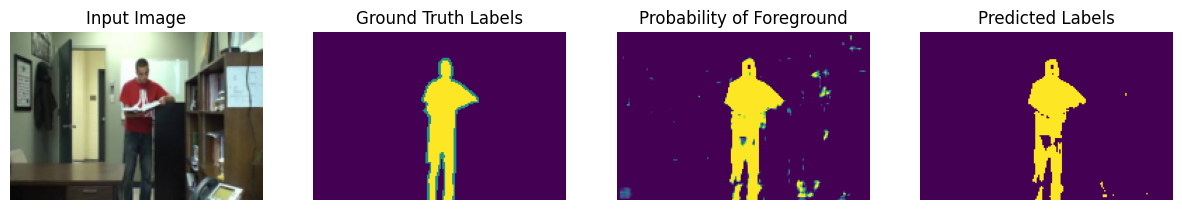

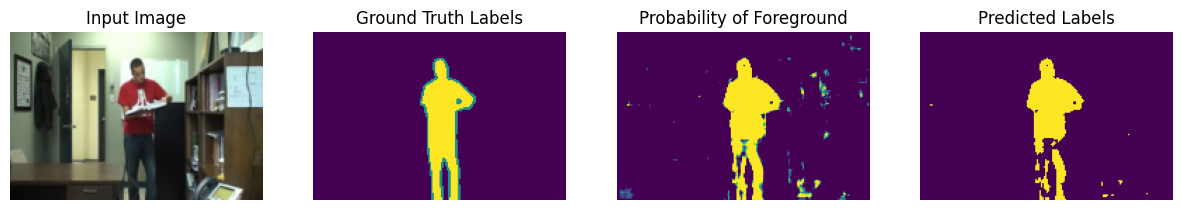

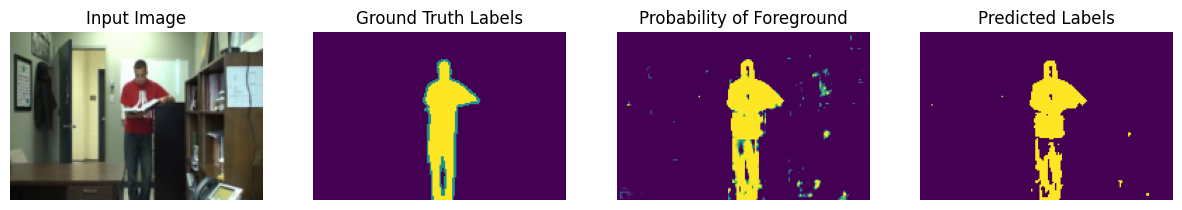

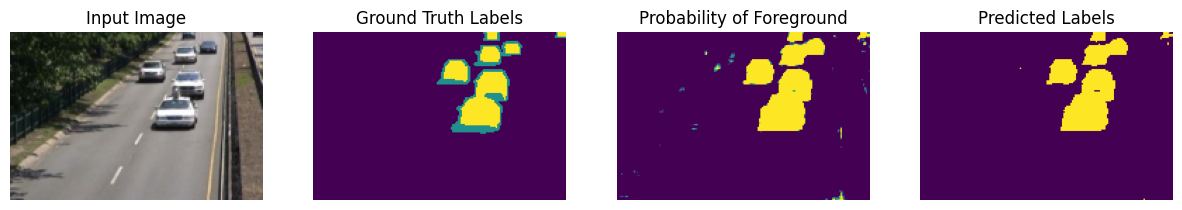

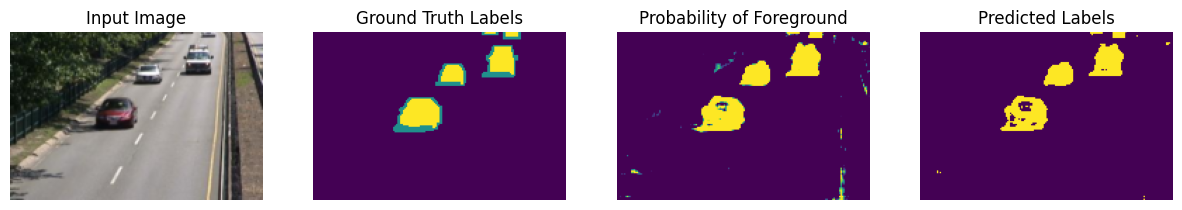

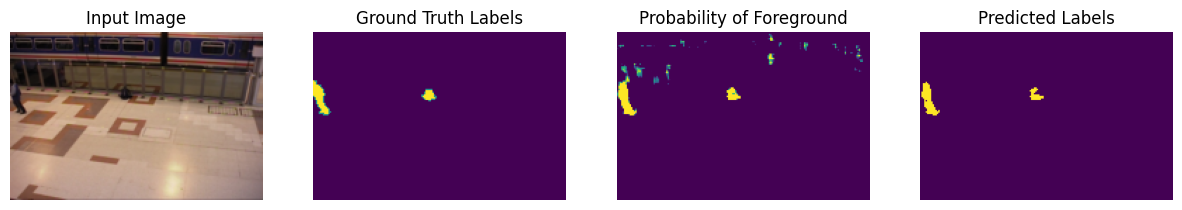

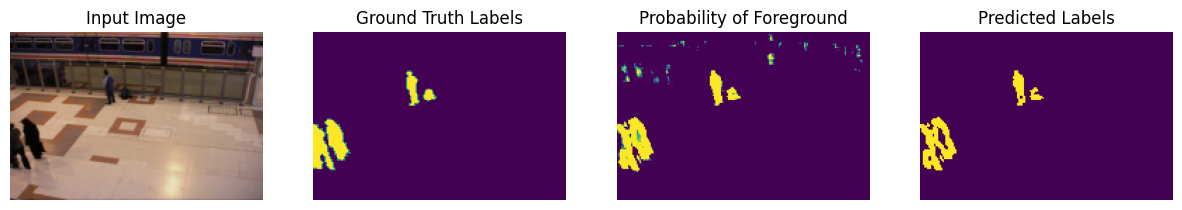

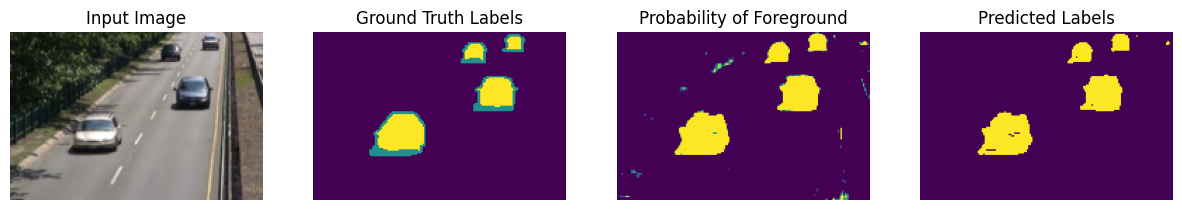

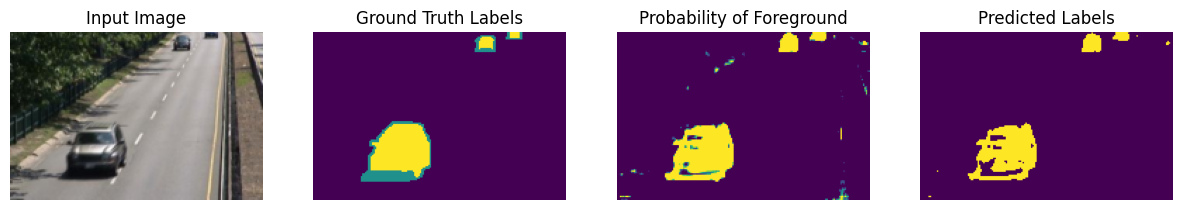

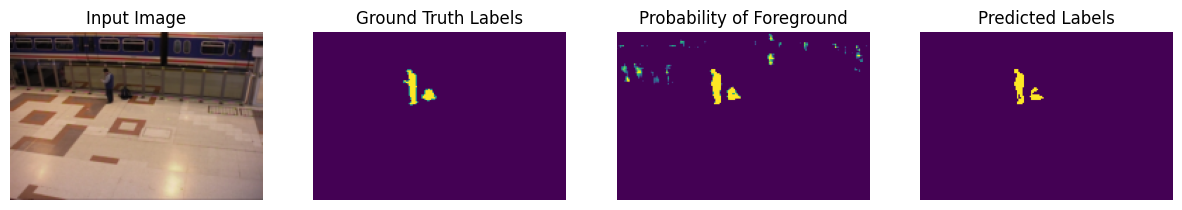

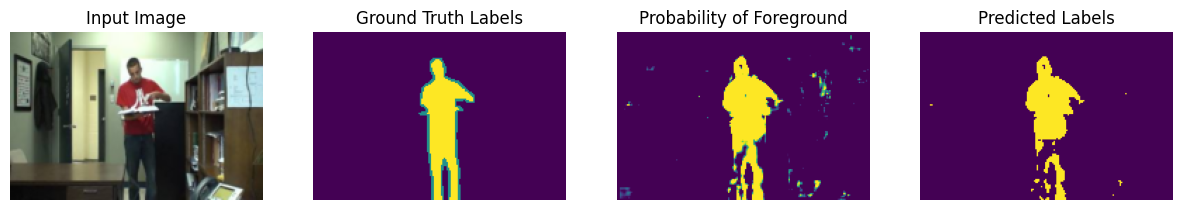

In [ ]:
visualize(model, test_dataloader)

<!-- END QUESTION -->

# Discussion


<!-- BEGIN QUESTION -->

1. Explain the impact of using different class weights when training the baseline model. Visualize your results below and see if your can notice any specific pattern or bias that the model has learned in the three different scenarios.


_Points:_ 5

Using different class weights significantly impacts the model's performance. With default weights ([0.25, 0, 1]), the model balances background and foreground penalties, achieving moderate F1 scores. When using [0.01, 0, 1], the model reduces penalties for background misclassification, leading to higher recall for foreground pixels but lower precision. With [1, 0, 1], equal penalties for background and foreground improve foreground detection but risk overfitting to rare classes. Visualizations show that lower weights for background reduce false negatives while higher weights improve overall foreground detection but may increase false positives.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

2. Explain the architectural choices of your two models. Describe about their performance. Try to reason about which specific choices (in architecture or hyperparameters) caused their specific behaviour. Describe your experiments with different hyperparameters.


_Points:_ 5

Model1 uses a deeper CNN with dropout for regularization, which improves generalization and prevents overfitting. Model2 employs a U-Net-inspired architecture, capturing multi-scale features for better segmentation. Model1 performs well with balanced datasets, while Model2 excels in detecting fine-grained details. Hyperparameter experiments showed that lower learning rates like 1e-4 stabilize training, while higher rates like 1e-3 cause divergence. Dropout in Model1 and skip connections in Model2 were key to their performance.

<!-- END QUESTION -->

# Submission Instructions


Follow the instructions provided on the [canvas assignment page](https://wustl.instructure.com/courses/147292/assignments/762182).

# AI Usage Summary

[as per course policy, we allow the use of AI assistants as part of completing homework assignments, however such usage must be acknowledged. If it is detected and not acknowledged, it will be considered a violation of academic integrity. As such, please summarize what AI tools you used to complete this assignment, including for understanding the concepts and generating source code. If you used code generation, please explain the extent to which you had to modify the solution for it to function correctly.]